# Edraak MOOC - Activity and Confidence Analysis

We modify the default analysis notebook to build an analysis
on a dataset from a different source.
Again we work with data about a MOOC (Massive Open Online Course)
but instead of building a new analysis we fit the data into
the existing data model and reuse the analysis on the model.

A conservative set of libraries is still used.
Further standard library libraries are also used during the
data preparation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
np.__version__, pd.__version__, matplotlib.__version__

('1.18.1', '1.0.1', '3.1.3')

Remember that a `jupyter` notebook follows the rule
of placing dependencies above the dependent code.
Oft one needs to run the cells above the current cell in order for the code to work.
Remember that all code state is forgotten once you shutdown `jupyter` notebook/lab,
in which case the notebook needs to be re-run.

For the main changes in the parts of the analysis we have:

- The *Data Model* is the same but the loading of data into it is completely different.
  Notably the data from Edraak is not cleansed from personal identifiers and we need
  to be careful to not expose sensitive information.

- *General Analysis* is common and mostly reused.
  Albeit there is no step start data in Edraak, and we need to remove
  that part of the analysis.

- *Extra Analysis* is just the use of question responses with more participant
  statistics.

![Wind](mooc-confidence-edraak-wind.svg)

<div style="text-align:right;"><sup>mooc-confidence-edraak-wind.svg</sup></div>

---

## Part 1: Data Model

The data model itself needs a few minimal changes, for Edraak we have:

- A fact table called `response`,
  with one main foreign key called `participant_id`,
  it represents the activity and responses of participants to the activity steps.

- The main dimension will be called `participant` and use `participant_id` as its primary key.
  The `participant` dimension will aggregate unto itself everything we know about each
  participant from all source of data.

- The `step` fact table in the original data model cannot be constructed from Edraak data.

In the `response` fact the primary key will be the uniqueness of `participant_id`,
`week`, `step` and `question`.

### Current Data

In order to fit our data model we build the fact and dimension as follows:

- `participant` is built from `student-profile` and a hashed
  (to protect personal data) `username` is renamed to `participant_id`.

- `response` is constructed from several data files with answers per questionnaire.
  The `username` is hashed in exactly the same fashion as in `participant`
  and again used as the `participant_id`.

### Loading the data

**The names of the CSV files may differ**, one must remember to verify the file names,
which must live in the same directory as the notebook.
**Also note that the filenames have the name of the MOOC course removed.**

Another worry with the Edraak data is the presence of personally identifiable data.
And this is an issue we need to handle before displaying any of the data.
We build a hasher function call from the first $8$ bytes ($16$ nibbles)
of a cryptographic hash.  $8$ bytes fit nicely in both `numpy` data types (`uint64`)
and processor words for very fast table linking.

In [2]:
import hashlib

def scramble_personal(data, hexadecimal=False):
    hexdigest = hashlib.sha1(data.encode('utf-8')).hexdigest()[:16]
    if hexadecimal:
        return hexdigest
    # 16 nibbles fit exactly in np.uint64
    return np.uint64(int(hexdigest, 16))

scramble_hex = lambda x: scramble_personal(x, hexadecimal=True)

As we load the profile data we apply the hasher function
on the sensitive columns right away.

We hash the `username` into a number for easy processing
and the names and emails into a hexadecimal representation.
Note that the file must be named **student-profile.csv** in order to load.

In [3]:
profile = pd.read_csv('student-profile.csv', index_col='id')
profile['username'] = profile['username'].apply(scramble_personal)
profile['name'] = profile['name'].apply(scramble_hex)
profile['email'] = profile['email'].apply(scramble_hex)
profile.drop(['mailing_address', 'goals'], axis=1, inplace=True)
profile[:3]

,username,name,email,language,location,year_of_birth,gender,level_of_education,enrollment_mode,verification_status,city,country
id,,,,,,,,,,,,
3006214,12910178080571563399,d8bab5ca42234804,77aab4eae8557a75,NaN,NaN,1998,m,NaN,honor,NaN,NaN,EG
4926586,10354132342401575959,db4ba2237ac29641,315d7718b527ccdb,NaN,NaN,1992,f,NaN,honor,NaN,NaN,EG
4885163,17642583103743342069,b9df86b8035d8c03,009e0ea7ba971e8b,NaN,NaN,2000,m,NaN,honor,NaN,NaN,LB


Hashes squeeze information into a small space,
where the same information should always be placed within the same place
within that space and distinct information should be placed in different places.
Cryptographic hashes are designed to spread the incoming information in
an uniform fashion within that space but two different pieces of information
can still end up assigned to the same location within that space as it is limited.

When two different pieces of information are placed in the same place,
i.e. the output of the hash is the same for different inputs,
it is called a hash collision.
On occasion a few collisions may happen.
Since we care about statistics hash collisions are rare enough that we
can consider them negligible and just remove them.

In [4]:
collision = len(profile) - len(profile.groupby('username').size())
profile = profile.groupby('username').first().reset_index()
print(f'hash collisions {collision}')

hash collisions 0


To build the answers to the questions into a data structure we
need to parse several files.
All files must follow a naming convention so that we will find them.
We will assume that all files with questionnaire answers are named as
**week-N-q-M.csv** where **N** is the week number and **M** the question number.
For example, data for week $2$ question $3$ must live in the file **week-2-q-3.csv**.

Also note that the most important piece of information is the value of the answer,
and in Edraak data these values are under the column named **إجابة**.
A change in the name of this column will break the code and should be checked.

In [5]:
import glob, re

def read_week(w, q, filename):
    week = pd.read_csv(filename)
    week = week.rename(columns={
        'إجابة': 'response',
        'username': 'participant_id',
    })
    week['week'] = w
    week['step'] = 1
    week['question'] = q
    week['participant_id'] = week.participant_id.apply(scramble_personal)
    return week[['participant_id', 'week', 'step', 'question', 'response']].dropna()

all_weeks = sorted(glob.glob('week-*'))
dfs = []
for w in all_weeks:
    groups = re.match('week-(\d+)-q-(\d+)', w).groups()
    groups = list(map(int, groups))
    groups.append(w)
    dfs.append(read_week(*groups))
week = dfs[0].append(dfs[1:])
week[:3]

,participant_id,week,step,question,response
0,17974442635216503513,1,1,1,5.0
1,15779273676961703902,1,1,1,3.0
3,1890423570833598262,1,1,1,4.0


We have hence renamed the columns to `response` and `participant_id`,
and hashed any possible identifiable data.

Since we again hashed the data we may have new collisions,
which we automatically remove.

In [6]:
groups = ['participant_id', 'week', 'step', 'question']
collision = len(week) - len(week.groupby(groups).size())
week = week.groupby(groups).first().reset_index()
print(f'hash collisions {collision}')

hash collisions 0


### Sanity Checks

A few assumptions are made about the data before we process it.
Some of these sanity checks will be repeated once we transition into
the data model specified above but the earlier we find possible issues the better.
**Each of the tests below should not fail and should return `True`.**
If that is not the case then one must go back to the files and rectify.

IDs for participants are unique.

In [7]:
len(profile.index.unique()) == len(profile)

True

Indexes such as weeks and steps must be integers.
Note that this also means that there are no null values
as `numpy` does not allow for null integers.

In [8]:
pd.api.types.is_integer_dtype(week.week)

True

In [9]:
pd.api.types.is_integer_dtype(week.step)

True

In [10]:
pd.api.types.is_integer_dtype(week.question)

True

### Transform (into the Data Model)

Now we can place the data we have into the data model we defined.
The naming convention is that we will never use the same variable
name for the loaded data and the data model table,
this naming convention ensures that columns can be re-run
without too much care for the order in which they are re-run.

**CONFIGURATION NEEDED** Edraak data does not provide us with
the ages of the participants but their age of birth.
I order to calculate the age of the participants correctly
we need to know in which year the MOOC has been run.
Since we are dealing with statistics we can ignore further
granularity such as days before or after a birthday.

In [11]:
# configuration, year the course did run
this_year = 2021

And with that we can calculate the ages and divide them in groups by decades.
We can also cleanup a few columns that have null values.

In [12]:
participant = profile.copy()
participant.loc[participant.gender.isnull(), 'gender'] = 'unknown'
participant.loc[participant.country.isnull(), 'country'] = 'unknown'
participant = participant.rename(columns={'username': 'participant_id'})
participant.set_index('participant_id', inplace=True)

def age_range(yob):
    try:
        y = int(yob)
        return (this_year - y)//10
    except ValueError:
        return np.nan

participant['age_range'] = participant.year_of_birth.apply(age_range)
participant['age_range'] = participant.age_range.fillna(int(participant.age_range.mean()))
participant['age_range'] = participant.age_range.apply(lambda x: f'{x*10:.0f}-{(x+1)*10:.0f}')
participant[:3]

,name,email,language,location,year_of_birth,gender,level_of_education,enrollment_mode,verification_status,city,country,age_range
participant_id,,,,,,,,,,,,
10493475746994014,949926d65939c3cc,5ca1f97efa7fd7e9,NaN,NaN,1991,m,NaN,honor,NaN,NaN,YE,30-40
14413915214086787,17ab607dd937c415,80c67bad7baf3e97,NaN,NaN,1981,m,b,honor,NaN,NaN,JO,40-50
28890453854225496,cf60ceca10f87f21,0c90e15ca67eea66,NaN,NaN,1991,m,a,honor,NaN,NaN,EG,30-40


Now we have the `participant` dimension that fits the data model.

A few statistics are meaningless because of how the columns are coded,
a good example is the education level in the Edraak data.
Thankfully the Edraak documentation provides a mapping from the codes
onto more meaningful names.
A mapping which we will use to build a new column with the more meaningful names.

In [13]:
from collections import defaultdict

education = defaultdict(
    lambda: 'unknown',
    p='doctorate',
    m='masters or professional degree',
    b='bachelors degree',
    a='associate degree',
    hs='secondary/high school',
    jhs='junior secondary/junior high/middle school',
    el='elementary/primary school',
    none='no formal education',
    other='other education',
    p_se='doctorate in science or engineering',
    p_oth='doctorate in another field')

def make_education(e):
    if not pd.isnull(e):
        e = e.lower()
    return education[e]

# we need to add a new column so re-running the cell does not break the data
participant['highest_education_level'] = participant.level_of_education.apply(make_education)
participant[:3]

,name,email,language,location,year_of_birth,gender,level_of_education,enrollment_mode,verification_status,city,country,age_range,highest_education_level
participant_id,,,,,,,,,,,,,
10493475746994014,949926d65939c3cc,5ca1f97efa7fd7e9,NaN,NaN,1991,m,NaN,honor,NaN,NaN,YE,30-40,unknown
14413915214086787,17ab607dd937c415,80c67bad7baf3e97,NaN,NaN,1981,m,b,honor,NaN,NaN,JO,40-50,bachelors degree
28890453854225496,cf60ceca10f87f21,0c90e15ca67eea66,NaN,NaN,1991,m,a,honor,NaN,NaN,EG,30-40,associate degree


The work to fit the `response` table has been mostly done
when we loaded the many files of questionnaire answers.
The only missing parts are related to steps,
data which does not exist for Edraak.

When we loaded the participant responses we dropped missing values.
Hence, to fit the table int the data model, we simply argue that
whoever answered the questions in the questionnaires must have started
and completed the steps.
It is a big assumption but in the face of missing information
it is the best we can do.

In [14]:
response = week.copy()
response['started'] = True
response['completed'] = True
response[:3]

,participant_id,week,step,question,response,started,completed
0,62904841179571038,1,1,1,3.0,True,True
1,62904841179571038,1,1,2,3.0,True,True
2,62904841179571038,1,1,3,4.0,True,True


The majority of the data is a time series,
hence the majority of comparisons are best made by self joins at a different time,
e.g. compare this week with next week.
Self joins may be tricky to read in code,
and it may therefore be quite difficult to change.
There are several unneeded condition in the code that are placed
in order to make the code robust against corner cases.
If you are changing the code please leave theses conditions be
no matter how obvious it seems that these are not needed for the data
currently processed.

### Sanity Checks (on the data model)

We can perform a second set of sanity check on the data model itself.
Again **each of the tests below should not fail and should return `True`.**
If all goes according to plan (no failures) we expect the rest
of the analysis to go smoothly.

Participant identifiers are unique.

In [15]:
len(participant.index) == len(participant.index.unique())

True

Every participant answered a question at most once.

In [16]:
response.groupby(['participant_id', 'week', 'step', 'question']).size().sum() == len(response)

True

This completes the data modeling part.
Let us say aloud the assumption made about the data,
assumptions that allow us to mathematically reason about the data.

- Questions of interest will always have numeric values,
  where the biggest value means better and the lowest means worse.

- A participant can only be enrolled once.

- Question of interest will always be about a participant
  confidence in himself or some course of action.
  This allows us to make several further assumptions
  on response aggregation.

- Step question answers are only answered once.
  When several answers are performed by the same participant
  we take the *mean* of the answer.  This is an assumption
  based on the fact that we are asking about a participant's confidence,
  and a change of heart is part of our evaluation.

---

## Part 2: General Analysis

Since we miss step data in the Edraak data set we cannot perform
graphs that plot on MOOC steps.
Yet the majority of questionnaire response graphs can be made without
any changes to the code.
As the data was fitted into the data model we can reuse the graphs.

**The most common error is to shutdown the notebook and then forget
to re-run the code cell containing the graphing functions before attempting the graphs.**
Beware of that.

**CONFIGURATION NEEDED**.
The following variable must be set to the groupings of week and step
in which the questionnaires of our interest are.
It must be a list of tuples (or equivalent) in the format `(week_number, step_number)`.
For example, `confidence = [(1, 3), (2, 6)]` tells us that the questionnaires of
interest are in week 1 step 3 and week 2 step 6.
There is no limitation as to how many questionnaires can be added or
that there must be a questionnaire per week.
As many questionnaires with any combination of week can be added.
A chronological order is not needed but recommended
as the graphs below assume chronological order.

In [17]:
# this is week 1 step 1, week 2 step 1 and week 3 step 1
confidence = [(1, 1), (2, 1), (3, 1)]

We then build a data structure based on the configuration provided.
Note that we do *not* fully sanity check the configuration,
it may happen that the following works without error and the graphs
below become empty.
If that happens the most likely cause is the incorrect setting
of the variable above.

The sanity check below shall capture most (but not all) such issues.
The following shall not error and shall print the number of question
responses per questionnaire.
If any of the numbers is $0$ (zero) then either a misconfiguration
happened and/or it points to an empty questionnaire.
The check will not catch questionnaires with only some questions missing.

In [18]:
all_steps = []
for w, s in confidence:
    all_steps.append(response[(response.week == w) & (response.step == s)])
list(map(len, all_steps))

[1909, 842, 653]

A questionnaire can be composed from several questions,
next we plot the questionnaires against questions
and build a histogram distribution of answers to each.

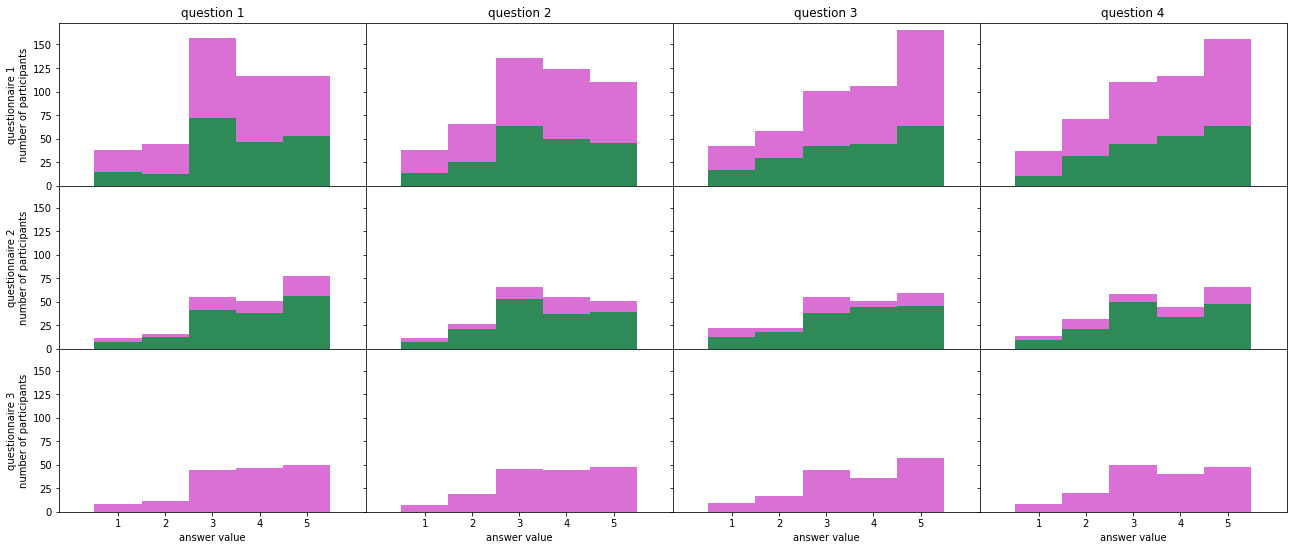

In [19]:
bins = int(response.response.max())
n_steps = len(all_steps)
n_questions = max(map(lambda x: len(x.question.unique()), all_steps))
fig, axs = plt.subplots(n_steps, n_questions, sharex=True, sharey=True, figsize=(22, n_steps*3))

for i in range(n_steps):
    for j in range(n_questions):
        this_step = all_steps[i]
        this_step = this_step[this_step.question == j + 1]
        next_step = all_steps[i+1] if i+1 < len(all_steps) else None
        ax = axs[i, j]
        _, edges, _ = ax.hist(this_step.response, bins=bins, color='orchid')
        if next_step is not None:
            next_step = next_step[['participant_id', 'question']]
            next_step = next_step[next_step.question == j + 1].copy()
            next_step.rename(columns={'question': 'next_week_question'}, inplace=True)
            qtmp = pd.merge(this_step, next_step, on='participant_id', how='inner')
            ax.hist(qtmp.response, bins=bins, color='seagreen')
        if j == 0:
            ax.set_ylabel(f'questionnaire {i+1}\nnumber of participants')
        if i == 0:
            ax.set_title(f'question {j+1}')
        if i+1 == n_steps:
            middles = (edges[:-1] + edges[1:]) / 2
            ticks = np.array(list(range(bins))) + 1
            ax.set_xticks(middles)
            ax.set_xticklabels(ticks)
            ax.set_xlim(middles[0]-1, middles[-1]+1)
            ax.set_xlabel(f'answer value')

plt.subplots_adjust(hspace=0, wspace=0)

**Figure 1: Distributions of Answers Across Questionnaires.**
The higher the answer value the higher is the confidence of the participant in that area.
The difference between colors again shows how many participants gave up on that week,
in this case we take a participant that gave up by checking if he/she has answered
the same question on the following questionnaire.
The scales between all graphs are the same,
the height can be compared to account for the change in confidence.
Remember that a change in confidence if the difference between a previous graph
(above from current) in green to the next graph (current) in indigo.

From this data we can see a consistent trend towards the right,
notably from answers around $3$ towards $4$ and $5$.

### Participant Statistics

We will build a data structure
for question answers similar to the one used in the previous graph,
but this time we will also build a structure for the participants
that did advance in the course.
Advanced to the next questionnaire, and the ones who
advanced through the complete course.

In [20]:
# We could loop only once for everything,
# but that would assume that we always have only a single step of interest per week.
# Looping several times allow for less assumptions on the data.
all_resp = []
all_resp_adv = []
all_resp_comp = []
for w, s in confidence:
    all_resp.append(response[(response.week == w) & (response.step == s)])

Once the structures are built we will join the tables with the participant
table which will allow us to filter by the statistics we may want.

Note that this is all dependent on the setting of confidence configuration
a few steps above.

In [21]:
def enrich_data(step_resp):
    enriched = pd.merge(participant, step_resp, left_index=True, right_on='participant_id', how='right')
    # sanity check
    if len(step_resp) != len(enriched):
        print('WARNING: incomplete RIGHT join')
    return enriched

We have all the building blocks and we run them all together.
Once again remember the order of the notebook,
the code below is heavily dependent on the code cells above.

A tiny sanity check is printed but it will not catch all possible issues,
notably problems with the confidence variable of weeks and steps where
the questionnaires are located.
If something goes wrong here,
the first place to check is the configuration a few steps back.

We build and enrich the responses structure.

In [22]:
first_resp = all_resp[0]
first_resp = first_resp[['participant_id', 'question', 'response']].copy()
first_resp.rename(columns={'response': 'first_response'}, inplace=True)
last_resp = all_resp[-1]
last_resp = last_resp[['participant_id', 'question', 'response']].copy()
last_resp.rename(columns={'response': 'last_response'}, inplace=True)
for i in range(len(all_resp)):
    this_resp = all_resp[i]
    next_resp = all_resp[i+1] if i+1 < len(all_resp) else None
    if next_resp is not None:
        # this grouping here is the main reason why we split into lists
        next_resp = next_resp[['participant_id', 'question', 'response']].copy()
        next_resp.rename(columns={'response': 'next_response'}, inplace=True)
        adv_step = pd.merge(this_resp, next_resp, on=['participant_id', 'question'], how='inner')
        adv_step['increase'] = adv_step.next_response - adv_step.response
        all_resp_adv.append(adv_step)
    else:
        # last element will always be empty
        df = this_resp.drop(this_resp.index)
        df['next_response'] = np.nan
        df['increase'] = .0
        all_resp_adv.append(df)
    comp_resp = pd.merge(this_resp, first_resp, on=['participant_id', 'question'], how='inner')
    comp_resp = pd.merge(comp_resp, last_resp, on=['participant_id', 'question'], how='inner')
    comp_resp['total_increase'] = comp_resp.last_response - comp_resp.first_response
    all_resp_comp.append(comp_resp)

all_resp = list(map(enrich_data, all_resp))
all_resp_adv = list(map(enrich_data, all_resp_adv))
all_resp_comp = list(map(enrich_data, all_resp_comp))
# sanity check
print('We got', len(all_resp_adv), 'questionnaires of interest')
print('And we got', len(all_resp_comp), 'questionnaires with completions')

We got 3 questionnaires of interest
And we got 3 questionnaires with completions


### Violin Graph

In order to display and compare distributions in time we will use groups of violin graphs.
A violin graph displays two probability distributions on each side of a vertical divide,
Each distribution follows a probability hence the area under each distribution is always the same,
this means that once can **compare the shape of the distribution but cannot compare the total height**.

Several graphic libraries have violin graph engines but these engines can be unstable,
at the time of writing all graph engines with extensive violin graph options are either
in alpha or beta stages of development and can change their APIs without warning.
To make the code as long lived as possible we write our own (tiny) violin graph engine
on top of the basic violin graph functionality in the stable `matplotlib` library.
The following code builds violin graphs.

In [23]:
def half_violin(x, y, *args, ax=None, left=False, mean=None, meadian=None, color=None, alpha=None, **kwargs):
    # force a clean plot so we can add these manualy
    kwargs['showmeans'] = False
    kwargs['showextrema'] = False
    kwargs['showmedians'] = False
    # allow for lists and single values
    if type(alpha) is not list and type(alpha) is not tuple and type(alpha) is not np.ndarray:
        alpha = [alpha]*len(x)
    if type(color) is not list and type(color) is not tuple and type(color) is not np.ndarray:
        color = [color]*len(x)
    # filters out empty arrays (sanity check first)
    filtered = zip(*[(x, y, c, a) for x, y, c, a in zip(x, y, color, alpha) if len(x) > 0])
    if not list(filtered):  # everything is empty, bail
        return
    x, y, color, alpha = zip(*[(x, y, c, a) for x, y, c, a in zip(x, y, color, alpha) if len(x) > 0])
    params = ax.violinplot(x, y, *args, **kwargs)
    for i, b in enumerate(params['bodies']):
        if not b.get_paths():  # empty graph - violinplots do not work well with missing data
            continue
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        clips = [m, np.inf]
        if left:
            clips = [-np.inf, m]
        # modify the paths to not go further right than the center
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], *clips)
        if color[i]:
            b.set_color(color[i]) 
        if alpha[i]:
            b.set_alpha(alpha[i])


def double_violin(xl, xr, y, *args, ax=None, color_left=None, color_right=None, **kwargs):
    half_violin(xl, y, *args, ax=ax, left=True, color=color_left, **kwargs)
    half_violin(xr, y, *args, ax=ax, color=color_right, **kwargs)

The question versus questionnaire graph - similar to the previous
one above - will allow us to understand how to read a group of
violin graphs in time.
We will call one side of the violin (a distribution) a half-violin
and a double sided violin (two distributions) a double-violin.
(Please ignore the mathematical inconsistency of these names.)

The first double-violin contains the distribution for the first questionnaire,
from which the left half-violin is the distribution of all answers from all
participants whilst the right half-violin is the distribution of answers
of the participants which advanced to the following step/questionnaire.
The next double-violin contains the answers for the next questionnaire,
again, all of them on the left and the part that advanced on the right.
Hence the complete graph can be read left to right:
all answers for first questionnaire versus answers to the first
by participants that did answer the second,
then the second questionnaire's all answers on the left of second
double-violin and so on.
Note that the answers to the first questionnaire by participants that answered
the second questionnaire are a different set of answers than the answers to
the second questionnaire.  i.e. the right half-violin of the previous double-violin
and the left half-violin of the current double-violin has the same participants
answering but it has their answers at two different points in time.

In order to see statistical significance across half-violins distributed from
a different number of data points we add transparency based on the amount of data.
The colors are more opaque (brighter in a white background) as more data is used.
For the case of a MOOC, where people give up as the course progresses,
we see more and more transparent violins as we go right (forward chronologically).

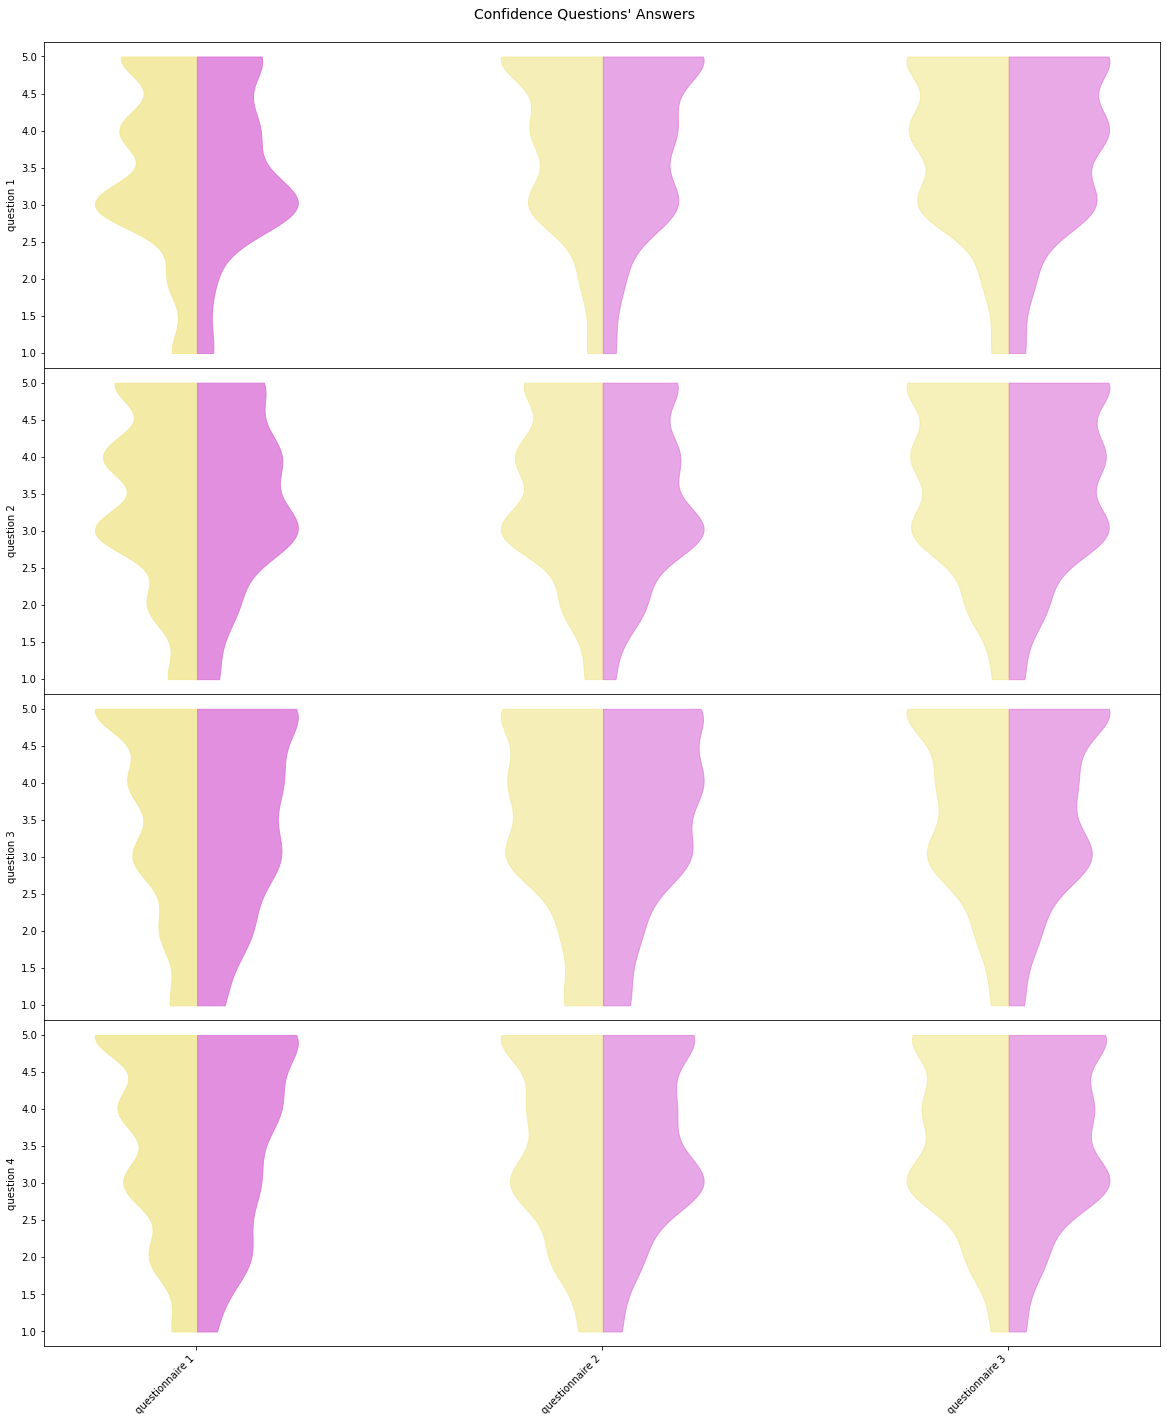

In [24]:
n_questions = max(map(lambda x: len(x.question.unique()), all_resp))
fig, ax = plt.subplots(n_questions, 1, sharex=True, figsize=(20, 6*n_questions))

ticks = list(range(len(all_resp)))
labels = list(map(lambda x: f'questionnaire {x+1}', ticks))
for i in range(n_questions):
    fil = lambda x: x[x.question == i+1].response.dropna().reset_index(drop=True)
    left = list(map(fil, all_resp))
    right = list(map(fil, all_resp_comp))
    atmp = np.array(list(map(len, left)))
    alpha = atmp / (atmp.sum() * 2) + .5  # weight size for alpha values
    double_violin(left, right, ticks, ax=ax[i], color_left='khaki', color_right='orchid', alpha=alpha)
    ax[i].set_ylabel(f'question {i+1}')

ax[-1].set_xticks(ticks)
ax[-1].set_xticklabels(labels, rotation=45, ha='right')
fig.suptitle("Confidence Questions' Answers", y=.9, fontsize=14)
plt.subplots_adjust(hspace=0)

**Figure 2: Violin graphs for Questionnaire Answers to each Question.**
We see similar distributions as in the previous graphs but the violin
graphs are probabilistic distributions as opposed to the previous raw histograms.
Where before missing questions from questionnaires appeared as empty graphs
here the missing questions appear as missing half-violins.
Note that the last half-violin will always be a half as there is no
next week/questionnaire to advance to.

From the current data we see the better shapes around specific
answer values, sometimes we see a move towards $3$ and $5$
and sometimes toward all high values: $3$, $4$ and $5$.

Remember that the violin graphs allow us to inspect the distribution shape
with more precision than raw histograms but the height of the distribution
is meaningless when compared because all distributions have the same area.
The total amount of data points is shown by the brightness of the color,
by the opaqueness, where less data makes for transparent (bleak) graphs.

### Generalized Statistics

The main reason for the violin graphs is that we can split the data across
statistics of participants and plot a set of violins for each split.
We can take any column from the participant table of the data model.

In [25]:
participant.columns

Index(['name', 'email', 'language', 'location', 'year_of_birth', 'gender',
       'level_of_education', 'enrollment_mode', 'verification_status', 'city',
       'country', 'age_range', 'highest_education_level'],
      dtype='object')

Let us take any of the participant statistics and check the values.
We can do this with `value_counts`.

In [26]:
participant['highest_education_level'].value_counts()

unknown                                       1405
bachelors degree                               677
secondary/high school                          261
masters or professional degree                 225
junior secondary/junior high/middle school      39
other education                                 36
associate degree                                34
doctorate                                       28
no formal education                              5
elementary/primary school                        4
Name: highest_education_level, dtype: int64

Note that the list of values is always in decreasing order,
which also means a decreasing statistical value.
For each grouping in the statistic we can plot a set of violin plots
as we did before for all questionnaires.
We will do so in the decreasing order of statistical significance
and the graphs shall vanish as we go from left to right.

The graphs may become unreadable if there are too many groupings
hence we will make a default limit of a maximum of $13$ groupings.
The value is arbitrary and woks well for a standard screen size
(around $20$ inches wide) and $3$ questionnaires.
One can use the `limit=` parameter to adjust the limit as needed.
One can even say `limit=None` to remove the limit altogether and
plot all groupings even if they exceed $13$ groupings.

In [27]:
# to keep things readable, we limit by 13 biggest values by default
def plot_response(stat, dropouts=False, start=0, limit=13):
    n_questions = max(map(lambda x: len(x.question.unique()), all_resp))
    estat = participant[stat].value_counts()
    fig, ax = plt.subplots(n_questions, 1, sharex=True, figsize=(20, 6*n_questions))
    all_adv = all_resp_comp
    if dropouts:
        all_adv = all_resp_adv

    colors = [('khaki', 'orchid'), ('seagreen', 'firebrick')] * int(np.ceil(len(estat) / 2))
    ticks = list(range(len(all_resp)))
    complete_ticks = []
    labels = list(map(lambda x: f'questionnaire {x}', ticks))
    complete_labels = []
    walk = enumerate(estat.index)
    if limit:
        walk = list(walk)[start:limit]
    for n_stat, cur_stat in walk:
        max_respondents = np.array([0]*len(all_resp))
        for i in range(n_questions):
            fil = lambda x: x[(x.question == i+1) & (x[stat] == cur_stat)].response.reset_index(drop=True)
            left = list(map(fil, all_resp))
            right = list(map(fil, all_adv))
            # weight size for alpha values (prevent division by zero)
            atmp = np.array(list(map(len, left)))
            alpha = atmp / (atmp.sum() * 2 + .1) + .5
            cleft, cright = colors[n_stat]
            double_violin(left, right, ticks, ax=ax[i], color_left=cleft, color_right=cright, alpha=alpha)
            ax[i].set_ylabel(f'question {i+1}')
            max_respondents = list(map(lambda x: max(*x), zip(max_respondents, atmp)))
            #print(max_respondents)
        complete_ticks += ticks
        ticks = list(map(lambda x: x+n_questions+1, ticks))
        def mklabels(l):
            q, stat = l
            return f'{cur_stat} ({stat}/{estat[cur_stat]}) - ' + q
        complete_labels += list(map(mklabels, zip(labels, max_respondents)))

    ax[-1].set_xticks(complete_ticks);
    ax[-1].set_xticklabels(complete_labels, rotation=45, ha='right')
    fig.suptitle(stat, y=.9, fontsize=14)
    plt.subplots_adjust(hspace=0)
    return estat

We can now plot against whichever statistic we may wish with a simple function call.

unknown                                       1405
bachelors degree                               677
secondary/high school                          261
masters or professional degree                 225
junior secondary/junior high/middle school      39
other education                                 36
associate degree                                34
doctorate                                       28
no formal education                              5
elementary/primary school                        4
Name: highest_education_level, dtype: int64

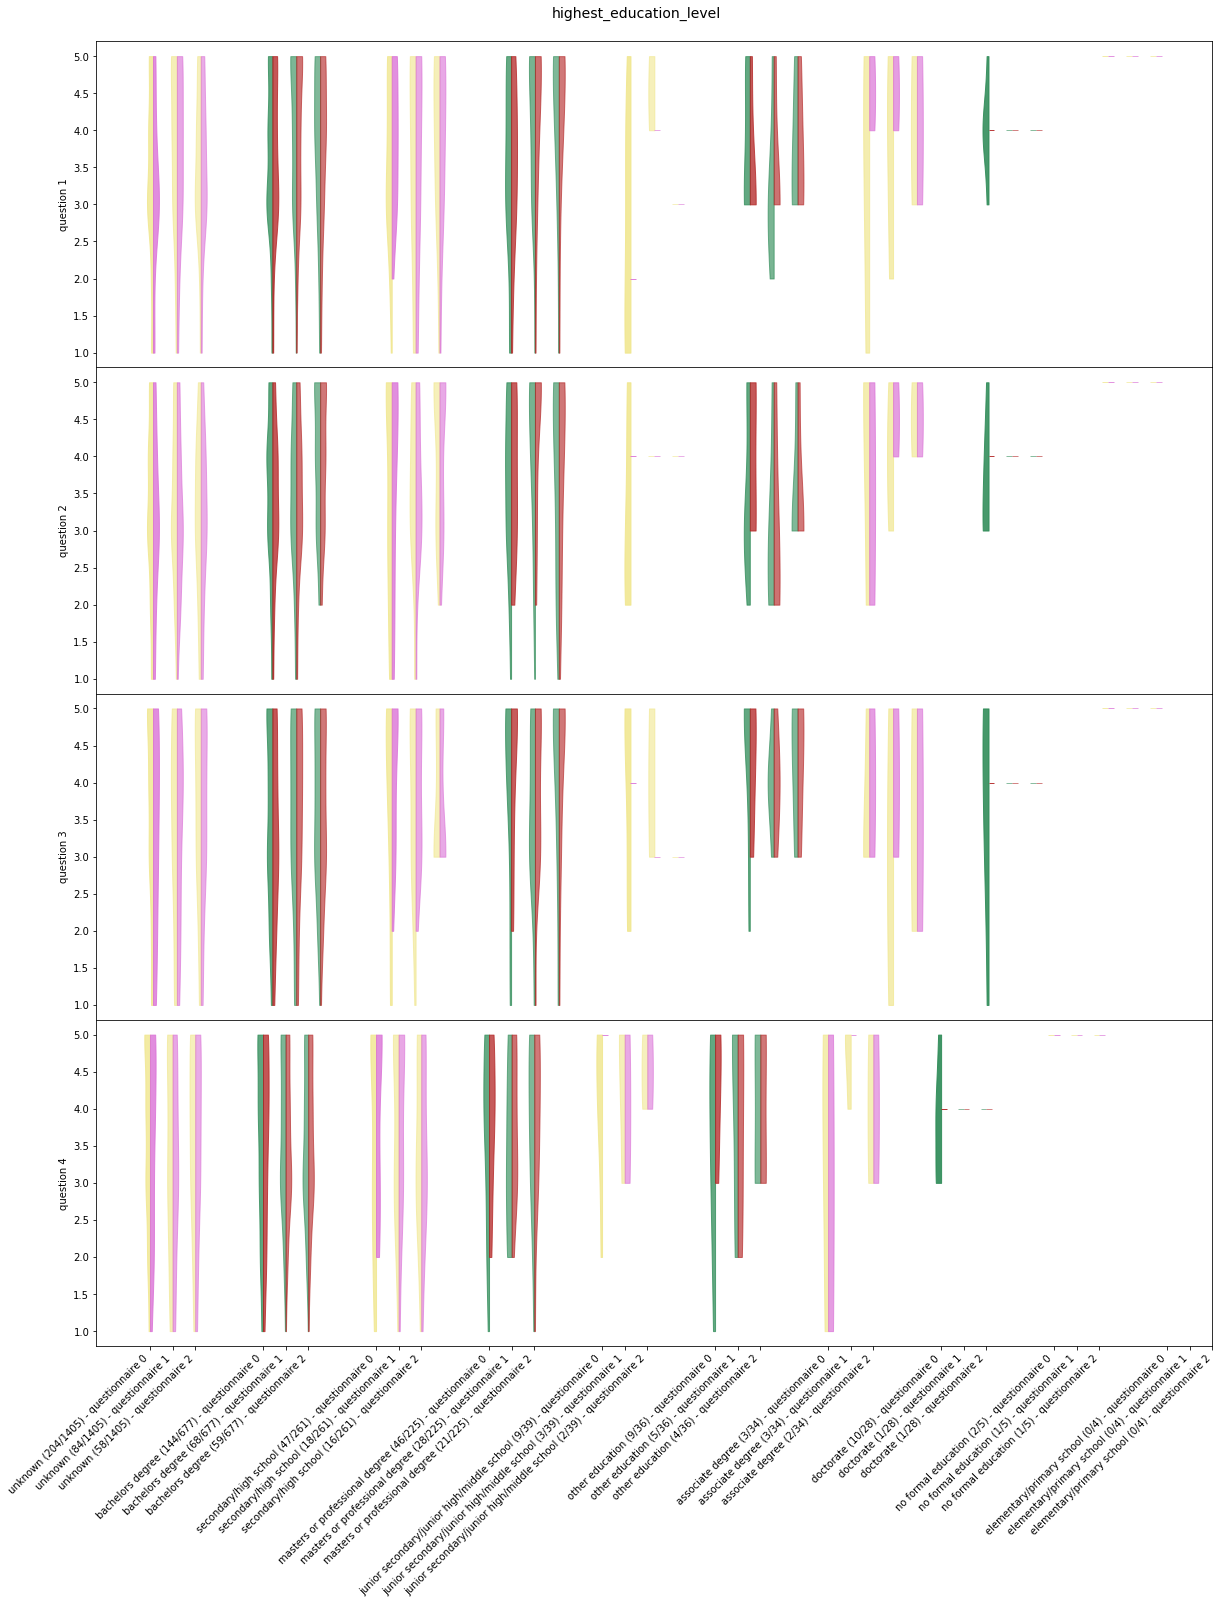

In [28]:
plot_response('highest_education_level')

**Figure 3: Violin Graphs for each Highest Education Level Grouping.**
The graphs use less and less statistically valuable groupings as we
read from left to right.
The transparency of the graphs indicates the statistical significance
within that grouping (amount of data used).
While the significance across groupings can be estimated from the bottom labels.
Each label contains the size of the *complete* grouping,
hence it is the amount of data used for the complete set of violin graphs.
Each violin graph set is separated by the color convention,
the sets alternate between yellow (khaki) left / pink (orchid) right
and green (sea green) left / orange (firebrick) right.

The function that generates the graph can be called with

    plot_response('statistic', dropouts=False, start=START_NUMBER, limit=LIMIT_NUMBER)

Where both `start=` and `limit=` are optional and `'statistic'` is a column from
the participant table - which must be placed in quotes.
On the left of the violins we plot all participants,
whilst on the right of the violin we plot the participants that kept on with
the course to the following weeks.
The `dropouts=` parameter, if set to a true value will include - in the right
half-violin - participants that continued the course for a while more but
then dropped out eventually from the course.
When `dropouts=False` (the default), the right half-violins include
only the participants that finished the MOOC.

Statistic groupings will be plotted in decreasing order,
the `start=` parameter is the number of groupings to ignore from the left.
Whilst the `limit=` is the grouping at which to stop plotting also from the left.
For example, to plot from the second grouping and plot $3$ groupings one would do:

    plot_response('higher_education_level', start=1, limit=4)

This plots the 2nd, 3rd and 4th groupings.
In the case of our data these are "university_degree", "university_masters" and "tertiary".
To plot just a single grouping one must set `start=` and `limit=` to adjacent numbers.
For example, to plot the grouping for "university_masters" in our data one would do:

    plot_response('higher_education_level', dropouts=False, start=2, limit=3)

The syntax for `start=` and `limit=` is zero based counting, borrowed from Python lists.
Let's try an example with a different statistic.

20-30      1509
30-40       561
40-50       310
10-20       236
50-60        81
60-70         8
0-10          7
70-80         1
120-130       1
Name: age_range, dtype: int64

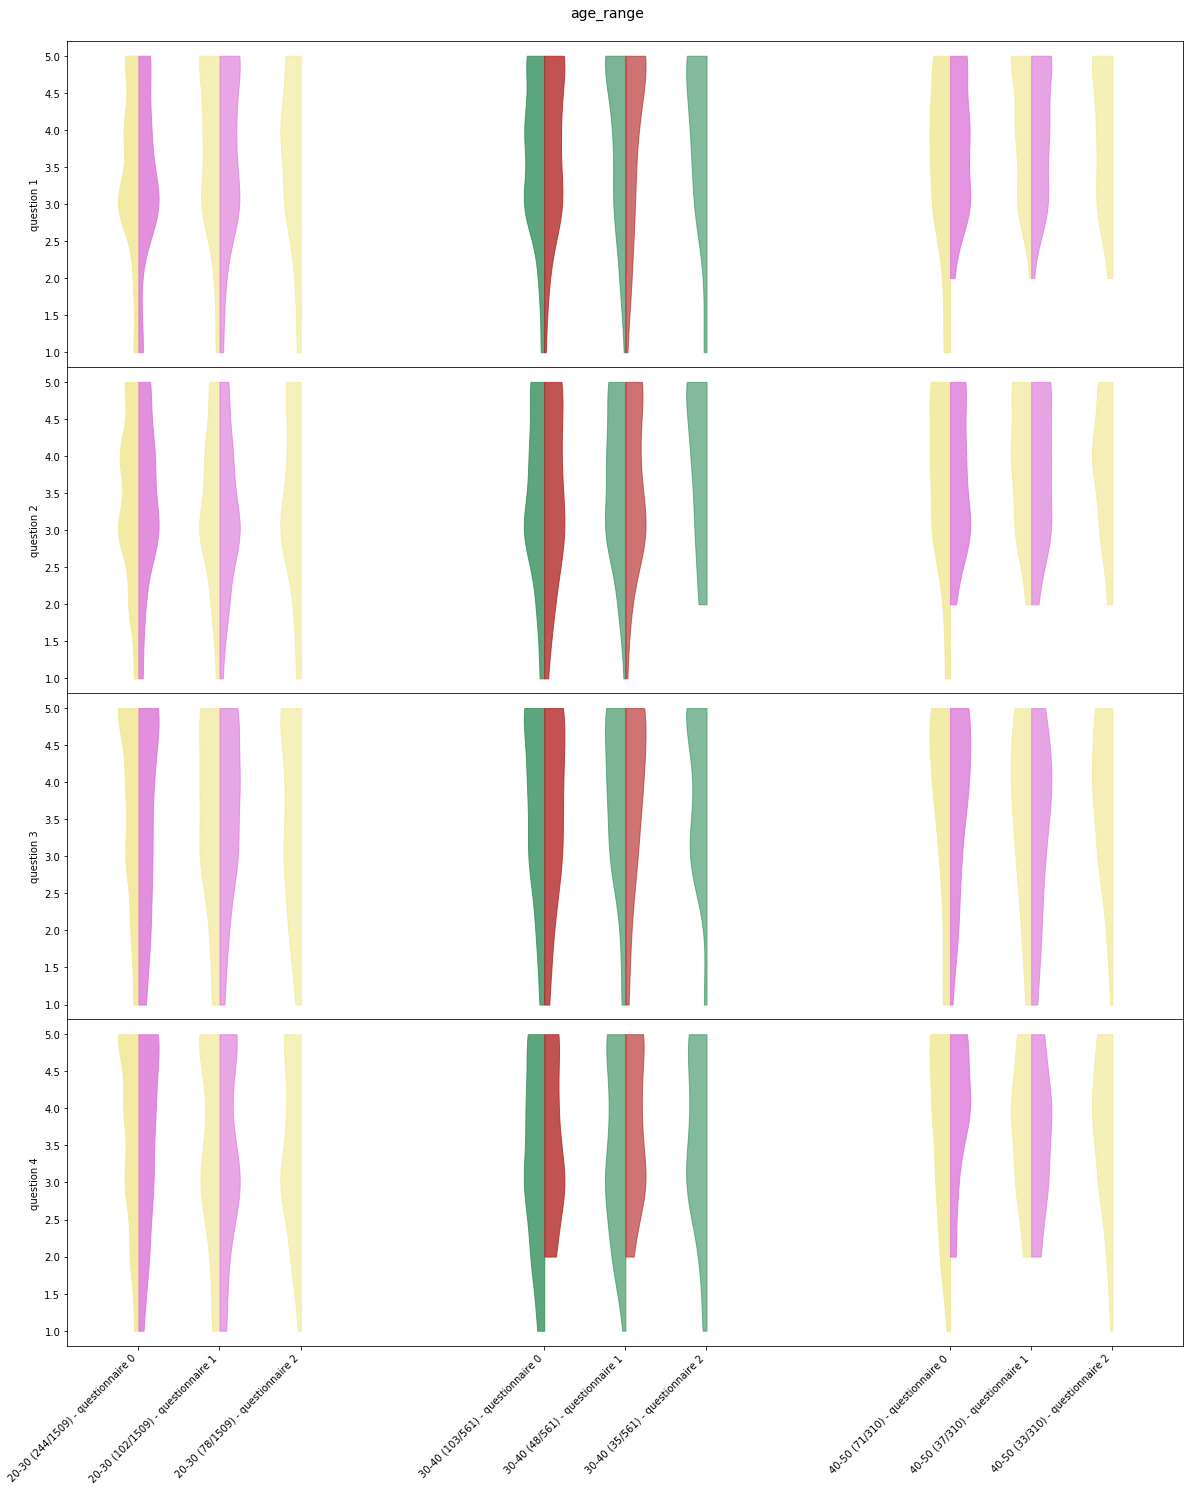

In [29]:
plot_response('age_range', dropouts=True, limit=3)

**Figure 4: Violin Graphs for Age Groupings.**
We can see a more varied number of trends,
some trends going up and some going down.
Often with considerable statistical value.

---

## Part 3: Extra Analysis

In this part we use the tools and extra data structures we have built above
to perform an analysis dependent on the dataset we currently use.

In the Edraak data we can try a few more statistics on responses.

EG         788
SA         324
DZ         238
JO         223
MA         218
unknown    211
LB         135
TN         105
SY          83
AE          82
SD          68
IQ          64
PS          48
YE          39
OM          20
LY          15
BH          11
TR           9
KW           6
MR           4
QA           3
GB           3
NL           2
KM           2
EH           2
TD           1
IL           1
IT           1
AF           1
US           1
UA           1
FR           1
SN           1
IN           1
CN           1
ME           1
Name: country, dtype: int64

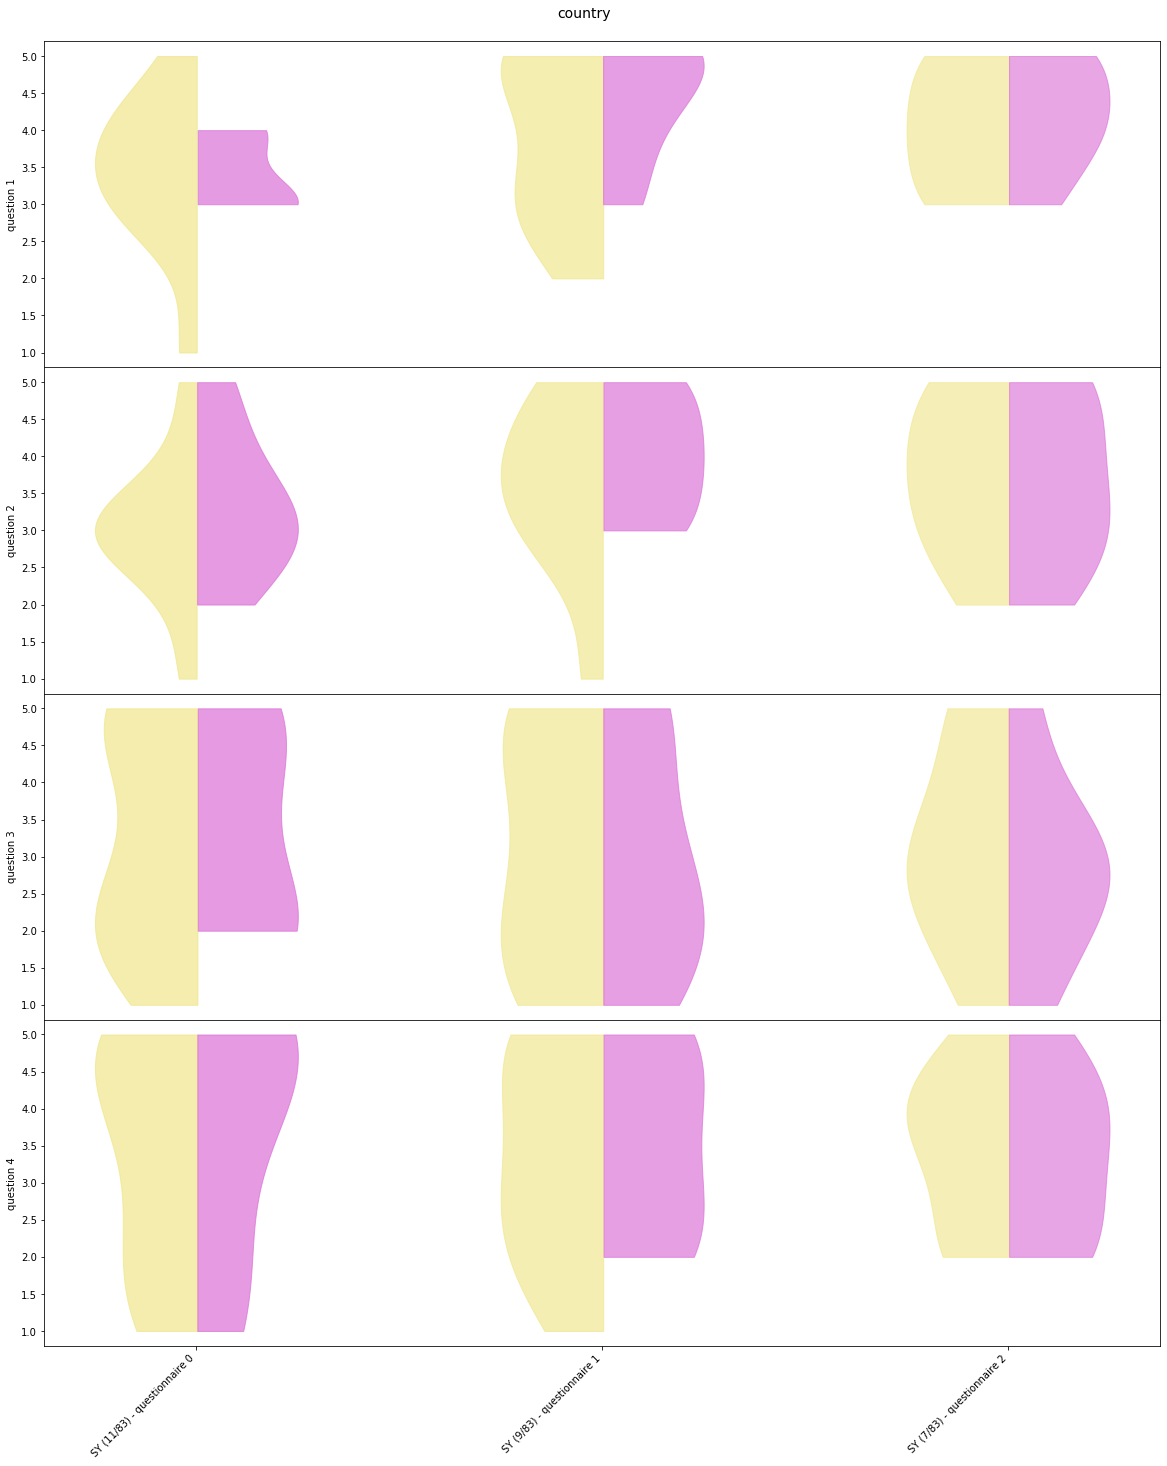

In [30]:
plot_response('country', start=8, limit=9)

**Figure 11: Questionnaire Answers in Syria.**
Here we used both `start=` and `limit=` to filter to a single
grouping of the country statistic.
At the time of writing Syria is still in a difficult state due
to ongoing conflict in several regions.
Despite that we can see confidence improvement during the MOOC
in all questions but question $3$ in the graph.

And this finishes the Edraak analysis notebook.
Feel free to use the remaining space to make further calls to
`plot_response` with more grouped statistics.

The general outlook on Edraak data is its larger amount than the data
used in the original default notebook (Future Learn data).
More data allows us for more significant statistics,
which balances out the lack of step data for this data set.